# 🤖 BERT baseline for beginners with Pytorch

[Competition]()

**Note that this training notebook is just a baseline model, which is designed for the beginner. The main aim is helping the NLP beginner to review pytorch and steps of fine tuning. If you want to get a higher rank in the competition, you can do more based on this basic tutorial.**

**some information**:
* Framework: Pytorch
* Model Architecture:
  * BERT -> Linear(768, 512) -> Linear(512, 512) -> Linear(512, 1)
* learning rate: 1e-5
* Batch Size: 8
* Epoch: 3
* Dropout: 0.2
* Criterion: BCEWithLogitsLoss
* Optimizer: Adam


## Tokenizer parameters
* **Max Lenght**: 416
* **Padding**: max_lenght
* **Truncation**: only_scond

## Loading dataset
Before that you should download the dataset file first. The detail steps of downloading can be found in this [notebook](https://github.com/Gary-code/Machine-Learning-Park/blob/main/Part3%20Industrial%20application/NBME%20-%20Score%20Clinical%20Patient%20Notes/NBME_Score_Clinical_Patient_Notes_EDA.ipynb) 

In [1]:
%cd /content/drive/MyDrive/dataset/NBMA
!ls

/content/drive/MyDrive/dataset/NBMA
features.csv  patient_notes.csv.zip  test.csv
kaggle.json   sample_submission.csv  train.csv


In [2]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 4.3 MB/s 
     |████████████████████████████████| 596 kB 51.0 MB/s 
     |████████████████████████████████| 895 kB 47.1 MB/s 
     |████████████████████████████████| 67 kB 4.5 MB/s 
     |████████████████████████████████| 6.5 MB 38.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
from ast import literal_eval
from itertools import chain

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer
import gc

## Some Useful Functions
### Dataset
merge `features.csv`, `patient_notes.csv` with `train.csv`





In [4]:
BASE_URL = "."

def process_feature_text(text):
  return text.replace("-OR-", ";-").replace("-", " ")


def loading_datasets():
  features = pd.read_csv(f"{BASE_URL}/features.csv")
  notes = pd.read_csv(f"{BASE_URL}/patient_notes.csv.zip")
  df = pd.read_csv(f"{BASE_URL}/train.csv")
  df["annotation_list"] = [literal_eval(x) for x in df["annotation"]]
  df["location_list"] = [literal_eval(x) for x in df["location"]]  # extraction and convert string to list

  merged = df.merge(notes, how="left")
  merged = merged.merge(features, how="left")

  merged["feature_text"] = [process_feature_text(x) for x in merged["feature_text"]]
  merged["feature_text"] = merged["feature_text"].apply(lambda x: x.lower())  #  Convert to lowercase, same as below
  merged["pn_history"] = merged["pn_history"].apply(lambda x: x.lower())

  return merged

In [5]:
tmp = loading_datasets()
tmp.head()  # preview the data after merge

,id,case_num,pn_num,feature_num,annotation,location,annotation_list,location_list,pn_history,feature_text
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],[dad with recent heart attcak],[696 724],hpi: 17yo m presents with palpitations. patien...,family history of mi; family history of myocar...
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],"[mom with ""thyroid disease]",[668 693],hpi: 17yo m presents with palpitations. patien...,family history of thyroid disorder
2,00016_002,0,16,2,['chest pressure'],['203 217'],[chest pressure],[203 217],hpi: 17yo m presents with palpitations. patien...,chest pressure
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']","[intermittent episodes, episode]","[70 91, 176 183]",hpi: 17yo m presents with palpitations. patien...,intermittent symptoms
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258'],[felt as if he were going to pass out],[222 258],hpi: 17yo m presents with palpitations. patien...,lightheaded


In [6]:
tmp.location_list[3], tmp.location[3]

(['70 91', '176 183'], "['70 91', '176 183']")

In [7]:
del tmp
gc.collect()

380

### Tokenizer

* ⁉ [Some explaination of params (Chinese)](https://zhuanlan.zhihu.com/p/341994096) & [more (Chinese)](https://zhuanlan.zhihu.com/p/403667311)
* ❤ [Some **Important** details (Chinese)](https://ifwind.github.io/2021/08/30/BERT%E5%AE%9E%E6%88%98%E2%80%94%E2%80%94%EF%BC%884%EF%BC%89%E9%97%AE%E7%AD%94%E4%BB%BB%E5%8A%A1-%E6%8A%BD%E5%8F%96%E5%BC%8F%E9%97%AE%E7%AD%94/#%E9%82%A3%E4%B9%88%E9%A2%84%E8%AE%AD%E7%BB%83%E6%9C%BA%E5%99%A8%E9%97%AE%E7%AD%94%E6%A8%A1%E5%9E%8B%E6%98%AF%E5%A6%82%E4%BD%95%E5%A4%84%E7%90%86%E8%B6%85%E9%95%BF%E6%96%87%E6%9C%AC%E7%9A%84%E5%91%A2)

In [8]:
def loc_list_to_ints(loc_list):
  """location_list -> index"""
  to_return = []
  for loc_str in loc_list:
    loc_strs = loc_str.split(";")
    for loc in loc_strs:
      start, end = loc.split()
      to_return.append((int(start), int(end)))  # add a tuple
  return to_return

In [9]:
def tokenize_with_add_labels(tokenizer, data, config):
  out = tokenizer(
      data["feature_text"],
        data["pn_history"],
        truncation=config['truncation'],
        max_length=config['max_length'],
        padding=config['padding'],
        return_offsets_mapping=config['return_offsets_mapping']
  )
  labels = [0.0] * len(out["input_ids"])  # input_ids: mapping indices
  out["location_int"] = loc_list_to_ints(data["location_list"])
  out["sequence_ids"] = out.sequence_ids()  # seperate the first and second param

  for idx, (seq_id, offsets) in enumerate(zip(out["sequence_ids"], out["offset_mapping"])):
    if not seq_id or seq_id == 0:
            labels[idx] = -1
            continue
    token_start, token_end = offsets
    for feature_start, feature_end in out["location_int"]:
      if token_start >= feature_start and token_end <= feature_end:
        labels[idx] = 1.0
        break

  out["labels"] = labels

  return out

### Predection and Score Function
This part is just designed as the description of overview, I will not explain it in details.

In [10]:
from sklearn.metrics import accuracy_score

def get_location_predictions(preds, offset_mapping, sequence_ids, test=False):
    all_predictions = []
    for pred, offsets, seq_ids in zip(preds, offset_mapping, sequence_ids):
        pred = 1 / (1 + np.exp(-pred))
        start_idx = None
        end_idx = None
        current_preds = []
        for pred, offset, seq_id in zip(pred, offsets, seq_ids):
            if seq_id is None or seq_id == 0:
                continue

            if pred > 0.5:
                if start_idx is None:
                    start_idx = offset[0]
                end_idx = offset[1]
            elif start_idx is not None:
                if test:
                    current_preds.append(f"{start_idx} {end_idx}")
                else:
                    current_preds.append((start_idx, end_idx))
                start_idx = None
        if test:
            all_predictions.append("; ".join(current_preds))
        else:
            all_predictions.append(current_preds)
            
    return all_predictions


def calculate_char_cv(predictions, offset_mapping, sequence_ids, labels):
    all_labels = []
    all_preds = []
    for preds, offsets, seq_ids, labels in zip(predictions, offset_mapping, sequence_ids, labels):

        num_chars = max(list(chain(*offsets)))
        char_labels = np.zeros(num_chars)

        for o, s_id, label in zip(offsets, seq_ids, labels):
            if s_id is None or s_id == 0:
                continue
            if int(label) == 1:
                char_labels[o[0]: o[1]] = 1

        char_preds = np.zeros(num_chars)

        for start_idx, end_idx in preds:
            char_preds[start_idx: end_idx] = 1

        all_labels.extend(char_labels)
        all_preds.extend(char_preds)

    results = precision_recall_fscore_support(all_labels, all_preds, average="binary", labels=np.unique(all_preds))
    accuracy = accuracy_score(all_labels, all_preds)
    

    return {
        "Accuracy": accuracy,
        "precision": results[0],
        "recall": results[1],
        "f1": results[2]
    }

## Construct Dataset

In [11]:
class MyDataset(Dataset):
  def __init__(self, data, tokenizer, config):
    super().__init__()
    self.data = data
    self.tokenizer = tokenizer
    self.config = config
  

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    data = self.data.iloc[idx]
    tokens = tokenize_with_add_labels(self.tokenizer, data, self.config)

    input_ids = np.array(tokens["input_ids"])
    attention_mask = np.array(tokens["attention_mask"])
    token_type_ids = np.array(tokens["token_type_ids"])

    labels = np.array(tokens["labels"])
    offset_mapping = np.array(tokens["offset_mapping"])
    sequence_ids = np.array(tokens["sequence_ids"]).astype('float16')

    return input_ids, attention_mask, token_type_ids, labels, offset_mapping, sequence_ids  

## Model
* **BERT** base
* with some FC layers

In [12]:
class MyModel(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.bert = AutoModel.from_pretrained(config['model_name'])  # BERT
    self.dropout = nn.Dropout(p=config['dropout'])
    self.config = config
    self.fc1 = nn.Linear(768, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 1)

  def forward(self, input_ids, attention_mask, token_type_ids):
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    logits = self.fc1(outputs[0])
    logits = self.fc2(self.dropout(logits))
    logits = self.fc3(self.dropout(logits)).squeeze(-1)
    return logits

### Hyperparameters

In [13]:
hyperparameters = {
    "max_length": 416,
    "padding": "max_length",
    "return_offsets_mapping": True,
    "truncation": "only_second",
    "model_name": "bert-base-uncased",
    "dropout": 0.2,
    "lr": 1e-5,
    "test_size": 0.2,
    "seed": 1268,
    "batch_size": 8
}

## Training(fine tuning)

### Prepare Dataset

* Train and Test split: 20%
  * Train: 11440
  * Test: 2860


In [14]:
train_df = loading_datasets()
X_train, X_test = train_test_split(train_df, test_size=hyperparameters['test_size'], random_state=hyperparameters['seed'])

print(f"Train Size:", len(X_train))
print(f"Test Size:", len(X_test))

Train Size: 11440
Test Size: 2860


In [15]:
tokenizer = AutoTokenizer.from_pretrained(hyperparameters['model_name'])

training_data = MyDataset(X_train, tokenizer, hyperparameters)
train_dataloader = DataLoader(training_data, batch_size=hyperparameters['batch_size'], shuffle=True)

testing_data = MyDataset(X_test, tokenizer, hyperparameters)
test_dataloader = DataLoader(testing_data, batch_size=hyperparameters['batch_size'], shuffle=False)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

### Start Training
Lets train the model with **BCEWithLogitsLoss** and **AdamW** as optimizer.

⚒ **Notes that:** on BCEWithLogitsLoss, the default value for reduction is `mean` (the sum of the output will be divided by the number of elements in the output). If we use this default value, it will produce negative loss. Because we have some negative labels. To fix this negative loss issue, we can use `none` as parameter. To calculate the mean, first, we have to filter out the negative values. [DOC](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)




In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = MyModel(hyperparameters).to(device)

criterion = torch.nn.BCEWithLogitsLoss(reduction = "none")
optimizer = optim.AdamW(model.parameters(), lr=hyperparameters['lr'])

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


🚴 [torch.masked_select](https://zhuanlan.zhihu.com/p/348035584)

In [17]:
def train(model, dataloader, optimizer, criterion):
  model.train()
  train_loss = []

  for batch in tqdm(dataloader):
    optimizer.zero_grad()
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    token_type_ids = batch[2].to(device)
    labels = batch[3].to(device)

    logits = model(input_ids, attention_mask, token_type_ids)
    loss = criterion(logits, labels)

    loss = torch.masked_select(loss, labels > -1.0).mean()
    train_loss.append(loss.item() * input_ids.size(0))

    loss.backward()
     # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    # it's also improve f1 accuracy slightly
    nn.utils.clip_grad_norm(model.parameters(), 1.0)
    optimizer.step()
  
  return sum(train_loss) / len(train_loss)

In [18]:
def eval_model(model, dataloader, criterion):
  model.eval()
  valid_loss = []
  preds = []
  offsets = []
  seq_ids = []
  valid_labels = []

  for batch in tqdm(dataloader):
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    token_type_ids = batch[2].to(device)
    labels = batch[3].to(device)
    offset_mapping = batch[4]
    sequence_ids = batch[5]

    logits = model(input_ids, attention_mask, token_type_ids)
    loss = criterion(logits, labels)
    loss = torch.masked_select(loss, labels > -1.0).mean()
    valid_loss.append(loss.item() * input_ids.size(0))

    preds.append(logits.detach().cpu().numpy())
    offsets.append(offset_mapping.numpy())
    seq_ids.append(sequence_ids.numpy())
    valid_labels.append(labels.detach().cpu().numpy())

  preds = np.concatenate(preds, axis=0)
  offsets = np.concatenate(offsets, axis=0)
  seq_ids = np.concatenate(seq_ids, axis=0)
  valid_labels = np.concatenate(valid_labels, axis=0)
  location_preds = get_location_predictions(preds, offsets, seq_ids, test=False)
  score = calculate_char_cv(location_preds, offsets, seq_ids, valid_labels)

  return sum(valid_loss) / len(valid_loss), score

In [19]:
import time

train_loss_data, valid_loss_data = [], []
score_data_list = []
valid_loss_min = np.Inf
since = time.time()
epochs = 3

In [20]:
model_name = "nbme_bert_v1.pth"
best_loss = np.Inf

best_loss = np.inf

for i in range(epochs):
  print("Epoch: {}/{}".format(i + 1, epochs))
  # first train model
  train_loss = train(model, train_dataloader, optimizer, criterion)
  train_loss_data.append(train_loss)
  print(f"Train loss: {train_loss}")
  # evaluate model
  valid_loss, score = eval_model(model, test_dataloader, criterion)
  valid_loss_data.append(valid_loss)
  score_data_list.append(score)
  print(f"Valid loss: {valid_loss}")
  print(f"Valid score: {score}")
    
  if valid_loss < best_loss:
    best_loss = valid_loss
torch.save(model.state_dict(), model_name)

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch: 1/3


  0%|          | 0/1430 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Train loss: 0.33713678334333325


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.16001605956276896
Valid score: {'Accuracy': 0.9915724284641838, 'precision': 0.6994638069705094, 'recall': 0.7541988263521522, 'f1': 0.7258008429193384}
Epoch: 2/3


  0%|          | 0/1430 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Train loss: 0.13474194019344715


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.13049554255721954
Valid score: {'Accuracy': 0.9925856352079511, 'precision': 0.7091010473235065, 'recall': 0.8455178793397509, 'f1': 0.7713242177713903}
Epoch: 3/3


  0%|          | 0/1430 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Train loss: 0.09400881656572008


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.1252957816778351
Valid score: {'Accuracy': 0.9934047508708448, 'precision': 0.7542179541595926, 'recall': 0.8218714768883878, 'f1': 0.7865927042841926}
Training completed in 97m 3s


### Visualize the results

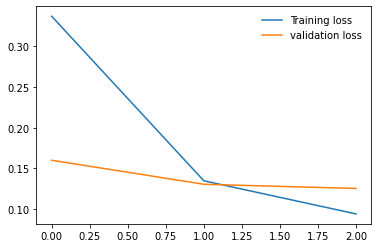

In [21]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [22]:
import pandas as pd

score_df = pd.DataFrame.from_dict(score_data_list)
score_df.head()

,Accuracy,precision,recall,f1
0,0.991572,0.699464,0.754199,0.725801
1,0.992586,0.709101,0.845518,0.771324
2,0.993405,0.754218,0.821871,0.786593


## Testing

1. load the trained model

In [23]:
model.load_state_dict(torch.load(model_name, map_location = device))

<All keys matched successfully>

In [24]:
def create_test_df():
  feats = pd.read_csv(f"{BASE_URL}/features.csv")
  notes = pd.read_csv(f"{BASE_URL}/patient_notes.csv.zip")
  test = pd.read_csv(f"{BASE_URL}/test.csv")

  merged = test.merge(notes, how = "left")
  merged = merged.merge(feats, how = "left")

  def process_feature_text(text):
      return text.replace("-OR-", ";-").replace("-", " ")
  
  merged["feature_text"] = [process_feature_text(x) for x in merged["feature_text"]]
  
  return merged


class SubmissionDataset(Dataset):
    def __init__(self, data, tokenizer, config):
      self.data = data
      self.tokenizer = tokenizer
      self.config = config
    
    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      example = self.data.loc[idx]
      tokenized = self.tokenizer(
          example["feature_text"],
          example["pn_history"],
          truncation = self.config['truncation'],
          max_length = self.config['max_length'],
          padding = self.config['padding'],
          return_offsets_mapping = self.config['return_offsets_mapping']
      )
      tokenized["sequence_ids"] = tokenized.sequence_ids()

      input_ids = np.array(tokenized["input_ids"])
      attention_mask = np.array(tokenized["attention_mask"])
      token_type_ids = np.array(tokenized["token_type_ids"])
      offset_mapping = np.array(tokenized["offset_mapping"])
      sequence_ids = np.array(tokenized["sequence_ids"]).astype("float16")

      return input_ids, attention_mask, token_type_ids, offset_mapping, sequence_ids


test_df = create_test_df()

submission_data = SubmissionDataset(test_df, tokenizer, hyperparameters)
submission_dataloader = DataLoader(submission_data, batch_size=hyperparameters['batch_size'], shuffle=False)

In [26]:
model.eval()
preds = []
offsets = []
seq_ids = []

for batch in tqdm(submission_dataloader):
  input_ids = batch[0].to(device)
  attention_mask = batch[1].to(device)
  token_type_ids = batch[2].to(device)
  offset_mapping = batch[3]
  sequence_ids = batch[4]

  logits = model(input_ids, attention_mask, token_type_ids)
  
  preds.append(logits.detach().cpu().numpy())
  offsets.append(offset_mapping.numpy())
  seq_ids.append(sequence_ids.numpy())

preds = np.concatenate(preds, axis=0)
offsets = np.concatenate(offsets, axis=0)
seq_ids = np.concatenate(seq_ids, axis=0)

location_preds = get_location_predictions(preds, offsets, seq_ids, test=True)

  0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
len(location_preds), len(test_df)

(5, 5)

In [28]:
test_df["location"] = location_preds

In [29]:
test_df[["id", "location"]].to_csv("submission.csv", index = False)
pd.read_csv("submission.csv").head()

,id,location
0,00016_000,696 724
1,00016_001,668 693
2,00016_002,203 217
3,00016_003,70 91
4,00016_004,222 258
